# **4.6.1 - "Rotífero ou tardígrado?": Trabalhando com as imagens** 🐛🐻🖼️
**Objetivo**: Implementar uma rede neural convolucional (CNN) utilizando PyTorch ou lightning. Treine esta rede neural em um conjunto de dados de imagens. Explique para o leitor como funciona a camada de convolução de uma CNN  e o motivo de utilizarmos este tipo de arquitetura quando estudamos imagens.

**Dupla**: Júlia Guedes A. dos Santos & Lorena Ribeiro Nascimento
***

### **Introdução** 💡

<p style="text-align:justify;">
O Dataset criado nesse notebook contêm imagens de Tardígrados e Rotíferos, visto que, devido a ética científica, invertebrados vem sendo cada vez mais
utilizados em análises biológicas e ecológicas. Dentre os invertebrados com aplicações biológicas, destaca-se os C. elegans, rotíferos e tardígrados.
</p>

<p style="text-align:justify;">
Rotíferos são organismos microscópicos utilizados em análises ecológicas e toxicológicas, por conta da sua sensibilidade físico-química a mudanças do ambiente. Já os tardígrados são seres de tamanho entre 3-5 mm, que possuem capacidade criptobiótica mediante estresses ambientais, permitindo alta resistência. Essa capacidade é foco de estudos na área de fármacos e terapias, além de análise ecológicas devido a resposta a mudanças ambientais.
</p>

<p style="text-align:justify;">
Todavia a distinção desses organismos em microscópicos óticos é dificultosa, devido a presença de liquens e diversos outros organismos semelhantas,por conta, também, das diferenças entre espécies de rotíferos e de tardígrados, além da posição, transparência e outros aspectos de visualização da imagem.
</p>

<p style="text-align:justify;">
Assim, nesse notebook pretende-se fazer a leitura do dataset criado a partir das imagens coletadas na internet e do microscópio ótico da Ilum-Escola de Ciência. Ao todo, foram coletadas 39 imagens de tardígrados e 32 de rotíferos, sendo que os conjuntos de teste e validação foram compostos por 10 figuras cada e o restante foi contemplado pelos dados de treino. Essas imagens foram compactadas em um arquivo em formato zip em que estão divididas em pastas de treino, validação e teste. Além disso, como é difícil encontrar imagens desses organismos, buscamos aumentar os dados de treino por meio de técnicas de modificações de imagens, tais como rotações e adição de ruídos.
</p>


### **Importação de bibliotecas** 📚

Em primeiro lugar, precisamos importar as bibliotecas necessárias para a resolução da tarefa proposta, as quais envolvem os processos de importação dos arquivos e plot das imagens.

In [3]:
# Módulos do matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Bibliotecas para definição de diretório
import zipfile
import os

#Image Augmentation
from skimage import exposure
from skimage.util import random_noise
from skimage import transform
from cv2 import resize
import numpy as np
import shutil

#Image redimension
import torchvision.transforms as transforms
from PIL import Image
import shutil

### **Download dos dados** 🎲

Primeiramente, precisamos importar as imagens. Para isso, por meio da função "files.upload" - própria da biblioteca Colab - iremos importar o zip que contém as imagens coletadas. Após descompactar os arquivos, esses serão contidos no diretório "/content/imagens", sendo que cada pasta contida no zip dará origem a uma nova pasta no diretório.

In [6]:
!unzip Rotiferos-tardigrados.zip

Archive:  Rotiferos-tardigrados.zip
   creating: Rotiferos-tardigrados/Teste/
   creating: Rotiferos-tardigrados/Teste/Rotiferos/
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem 31.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem23.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem24.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem25.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem26.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem27.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem28.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem29.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem30.jpg  
  inflating: Rotiferos-tardigrados/Teste/Rotiferos/Imagem32.jpg  
   creating: Rotiferos-tardigrados/Teste/Tardigrados/
  inflating: Rotiferos-tardigrados/Teste/Tardigrados/grado.jpg  
  inflating: Rotiferos-tardigrados/Teste/Tardigrados/gradoss.jpg  
  inflating: Rotiferos-

In [7]:
zip_path = "Rotiferos-tardigrados.zip"  # Caminho para seu zip
# extract_path = "/content/imagens"     # Pasta onde os arquivos serão extraídos
extract_path = ""
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [9]:
os.listdir("Rotiferos_tardigrados")

['Rotiferos-tardigrados']

Após baixar os dados, por meio da biblioteca Matplotlib, podemos visualizar as imagens.

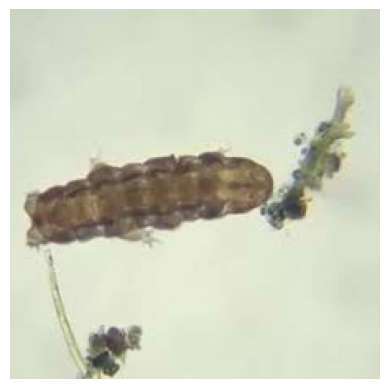

In [12]:
img_path = os.path.join(extract_path, "Rotiferos-tardigrados/Treino/Tardigrados/imagem12.jpg")
img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### **Data Augmentation** 🐥➡️🐓

Um dos principais desafios que podem ser enfrentados durante o treinamento de redes neurais é a disponibilidade limitada de dados. Isso, além de tornar o modelo não muito representativo, pode aumentar o risco de *overfitting*.

Para a mitigação desse problema, duas principais estratégias são comumente utilizadas: criação de dados sintéticos e *data augmentation*. Essa segunda técnica consiste na manipulação - através de transformações geométricas ou adição de ruídos, por exemplo - das imagens originais destinadas para o treino da rede neural. A partir disso, é possível deixar a base de dados mais robusta e representativa para o problema abordado. [1]

#### **Transformações geométricas: Rotação vertical e horizontal** 🔄️

De forma simples, transformações geométricas podem ser entendidas como operações aplicadas a uma figura, resultando em outra figura que mantém características geométricas idênticas ou equivalentes à original.

Existem diferentes operações que podem ser consideradas como transformações geométricas, como translação, reflexão e rotação. Essa última, apesar de poder ser realizada a partir da utilização de diferentes centros de rotação, também pode ser feita mediante a rotações nos eixos verticais e horizontal.

Dessa forma, a partir da utilização das funções fliplr e fliprud da biblioetca Numpy, iremos, respectivamente, testar a rotação da imagem utilizada como teste ("imagem12.png" da pasta de treino da classe dos tardigrados) na vertical e horizontal. [2]

**Rotação Vertical**

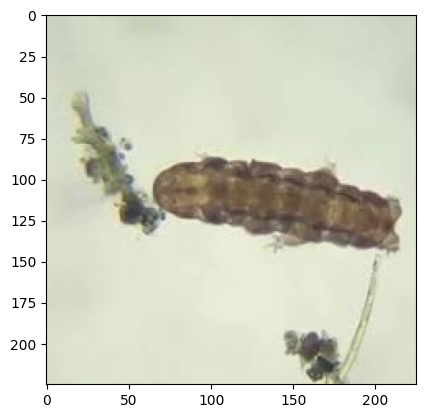

In [13]:
horiz = np.fliplr(img)
plt.imshow(horiz)

**Rotação Horizontal**

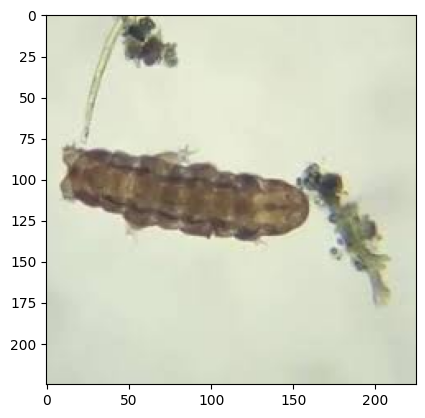

In [14]:
vert = np.flipud(img)
plt.imshow(vert)

#### **Ruído Gaussiano** 🔔

Como outra forma de induzir a criação de novas imagens, é possível adicionar ruídos às imagens pré-existentes. Dentre um dos mais utilizados, destaca-se o ruído gaussiano, o qual é uma forma de ruído aleatório na qual a função de densidade probabilidade (pdf) segue uma distribuição normal, tal como a demonstrada pela figura 1.

No contexto abordado, o ruído gaussiano é particularmente relevante, já que esse tipo de interferência é comumente observado em imagens obtidas por microscopia óptica.

Para a adição do ruído às imagens, a função random_noise, também da biblioteca Numpy, pode ser utilizada, com a especificação do argumento "mode" para "gaussian" (indicativo da aplicação do ruído gaussiano).

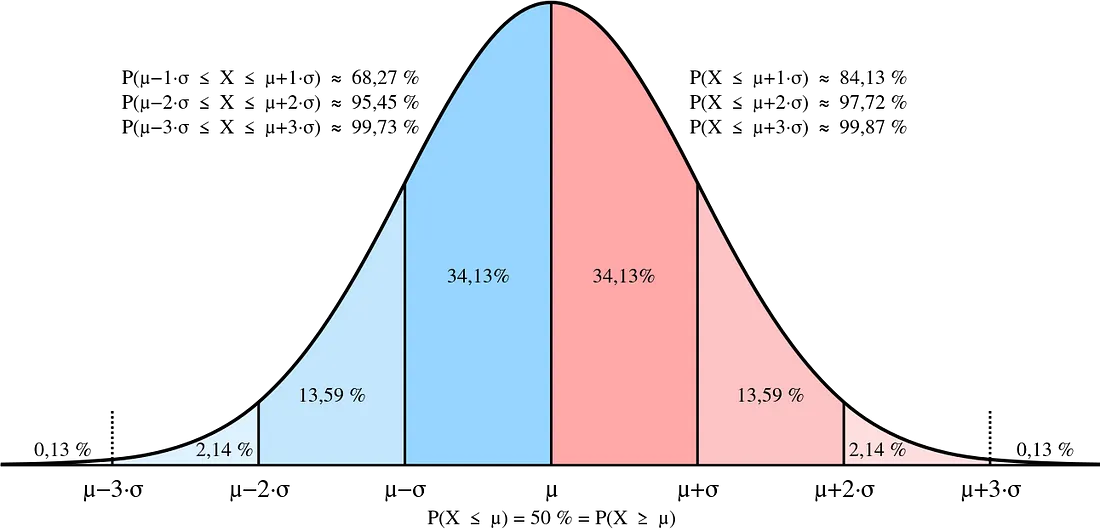

<p style="text-align:center;">
[Figura 1: Distribuição Gaussiana]
</p>

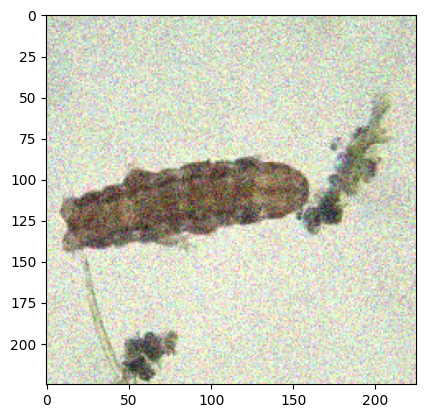

In [15]:
noise = random_noise(img, mode="gaussian", clip=True)
plt.imshow(noise)

**Manipulação das imagens** 🔔🔄️➡️🖼️

Partindo das técnicas abordadas anteriormente, a função "Augmentation" será definida. Nela, dado um determinado diretório, cada imagem contida ou será rotacionada (verticalmente ou horizontalmente) ou receberá adição de ruído gaussiano, sendo que a escolha dependerá do sorteio realizado por meio da biblioteca Random. Ao final, em ambas as pastas contidas no diretório de treino (referentes as labels Tardigrados e Rotíferos), as imagens serão "duplicadas", com a duplicata sendo indicada pela inserção do nome da operação realizada ao final do título da figura.

In [16]:
import random
def augmentation(caminho):
  num_imagem = 0
  for i in os.listdir(caminho):
    img_path = os.path.join(f"{caminho}{i}")  # Substitua pelo nome da imagem
    img = mpimg.imread(img_path)
    num_imagem += 1
    sorteio = random.choices(['gauss_noise', 'horizontal','vertical'])   #sorteia o tipo de modificação

    if sorteio == 'gauss_noise':
      noise = random_noise(img, mode="gaussian", clip=True)

    elif sorteio == 'horizontal':
      horiz = np.fliplr(img)

    else:
      vert = np.flipud(img)

    plt.savefig(f"{caminho}{num_imagem}_{sorteio}.png")


In [18]:
augmentation(caminho='Rotiferos-tardigrados/Treino/Tardigrados/') # aplicação da função

<Figure size 640x480 with 0 Axes>

In [19]:
tardigrados = os.listdir('Rotiferos-tardigrados/Treino/Tardigrados/') # listagem de todos os arquivos contidos no diretório
tardigrados

["10_['vertical'].png",
 "11_['gauss_noise'].png",
 "12_['vertical'].png",
 "13_['gauss_noise'].png",
 "14_['vertical'].png",
 "15_['gauss_noise'].png",
 "16_['gauss_noise'].png",
 "17_['vertical'].png",
 "18_['vertical'].png",
 "19_['vertical'].png",
 "1_['vertical'].png",
 "2_['horizontal'].png",
 "3_['gauss_noise'].png",
 "4_['gauss_noise'].png",
 "5_['vertical'].png",
 "6_['vertical'].png",
 "7_['horizontal'].png",
 "8_['gauss_noise'].png",
 "9_['horizontal'].png",
 'Captura de tela 2025-04-12 155025.png',
 'Captura de tela 2025-04-12 155222.png',
 'Captura de tela 2025-04-12 155323.png',
 'image5.jpg',
 'imagem10.jpg',
 'imagem11.jpg',
 'imagem12.jpg',
 'imagem15.jpg',
 'imagem16.jpg',
 'imagem17.jpg',
 'imagem18.jpg',
 'imagem19.jpg',
 'imagem4.jpg',
 'imagem6.jpg',
 'imagem7.jpg',
 'imagem8.jpg',
 'imagem9.jpg',
 'imagem_complicada.jpg',
 'tardigrado-microscopio.jpg']

In [21]:
for arquivo in tardigrados:
  if arquivo.lower().endswith(('.jpg', '.jpeg')):
    nome_arquivo_t = os.path.splitext(arquivo)[0]
    plt.savefig(f"Rotiferos-tardigrados/Treino/Tardigrados/{nome_arquivo_t}.png")
  else:
    continue


<Figure size 640x480 with 0 Axes>

In [22]:
"""Redimensionando as imagens para o mesmo tamanho com Pytorch"""
numero = 1
for arquivo in tardigrados:
    # Abre a imagem
    img = Image.open(f"Rotiferos-tardigrados/Treino/Tardigrados/{arquivo}")

    # Converte para RGB se estiver em RGBA ou outros modos
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Redimensiona com PyTorch
    resize_transform = transforms.Resize((32, 32))

    resized_img = resize_transform(img)

    pasta_saida = "imagens_redimensionadas"

    # Verifica se o arquivo já existe
    if os.path.exists(f'Rotiferos-tardigrados/Treino/Tardigrados/{arquivo}'):
        os.remove(f'Rotiferos-tardigrados/Treino/Tardigrados/{arquivo}')

    resized_img.save(f'Rotiferos-tardigrados/Treino/Tardigrados/resized_image{numero}.jpg')

    numero += 1


In [23]:
os.listdir('Rotiferos-tardigrados/Treino/Tardigrados')

['image5.png',
 'imagem10.png',
 'imagem11.png',
 'imagem12.png',
 'imagem15.png',
 'imagem16.png',
 'imagem17.png',
 'imagem18.png',
 'imagem19.png',
 'imagem4.png',
 'imagem6.png',
 'imagem7.png',
 'imagem8.png',
 'imagem9.png',
 'imagem_complicada.png',
 'resized_image1.jpg',
 'resized_image10.jpg',
 'resized_image11.jpg',
 'resized_image12.jpg',
 'resized_image13.jpg',
 'resized_image14.jpg',
 'resized_image15.jpg',
 'resized_image16.jpg',
 'resized_image17.jpg',
 'resized_image18.jpg',
 'resized_image19.jpg',
 'resized_image2.jpg',
 'resized_image20.jpg',
 'resized_image21.jpg',
 'resized_image22.jpg',
 'resized_image23.jpg',
 'resized_image24.jpg',
 'resized_image25.jpg',
 'resized_image26.jpg',
 'resized_image27.jpg',
 'resized_image28.jpg',
 'resized_image29.jpg',
 'resized_image3.jpg',
 'resized_image30.jpg',
 'resized_image31.jpg',
 'resized_image32.jpg',
 'resized_image33.jpg',
 'resized_image34.jpg',
 'resized_image35.jpg',
 'resized_image36.jpg',
 'resized_image37.jpg',
 '

Fazendo o aumento dos dados das imagens de treino para os Rotiferos.

In [24]:
augmentation('Rotiferos-tardigrados/Treino/Rotiferos/')

<Figure size 640x480 with 0 Axes>

In [25]:
rotiferos = os.listdir('Rotiferos-tardigrados/Treino/Rotiferos/')

In [26]:
for arquivo in rotiferos:
  if arquivo.lower().endswith(('.jpg', '.jpeg')):
    nome_arquivo_r = os.path.splitext(arquivo)[0]
    plt.savefig(f"Rotiferos-tardigrados/Treino/Rotiferos/{nome_arquivo_r}.png")
  else:
    continue

<Figure size 640x480 with 0 Axes>

In [27]:
"""Redimensionando as imagens para o mesmo tamanho com Pytorch"""
numero = 1
for arquivo in rotiferos:
    # Abre a imagem
    img = Image.open(f"Rotiferos-tardigrados/Treino/Rotiferos/{arquivo}")

    # Converte para RGB se estiver em RGBA ou outros modos
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Redimensiona com PyTorch
    resize_transform = transforms.Resize((32, 32))

    resized_img = resize_transform(img)

    pasta_saida = "imagens_redimensionadas"

    # Verifica se o arquivo já existe
    if os.path.exists(f'Rotiferos-tardigrados/Treino/Rotiferos/{arquivo}'):
      os.remove(f'Rotiferos-tardigrados/Treino/Rotiferos/{arquivo}')

    resized_img.save(f'Rotiferos-tardigrados/Treino/Rotiferos/resized_image{numero}.jpg')

    numero += 1


In [28]:
os.listdir("Rotiferos-tardigrados/Treino/Rotiferos")

['Imagem1.png',
 'Imagem10.png',
 'Imagem11.png',
 'Imagem12.png',
 'Imagem2.png',
 'Imagem3.png',
 'Imagem4.png',
 'Imagem5.png',
 'Imagem6.png',
 'Imagem7.png',
 'Imagem8.png',
 'Imagem9.png',
 'resized_image1.jpg',
 'resized_image10.jpg',
 'resized_image11.jpg',
 'resized_image12.jpg',
 'resized_image13.jpg',
 'resized_image14.jpg',
 'resized_image15.jpg',
 'resized_image16.jpg',
 'resized_image17.jpg',
 'resized_image18.jpg',
 'resized_image19.jpg',
 'resized_image2.jpg',
 'resized_image20.jpg',
 'resized_image21.jpg',
 'resized_image22.jpg',
 'resized_image23.jpg',
 'resized_image24.jpg',
 'resized_image3.jpg',
 'resized_image4.jpg',
 'resized_image5.jpg',
 'resized_image6.jpg',
 'resized_image7.jpg',
 'resized_image8.jpg',
 'resized_image9.jpg']

Para fazer o download da versão atualizada desses arquivos em formato zip, podemos utilizar o módulo shutil. [5]

In [29]:
shutil.make_archive("dataset_rotiferos_tardigrados_aumentado", "zip", "Rotiferos-tardigrados",  )

'c:\\Users\\julia24002\\OneDrive - ILUM ESCOLA DE CIÊNCIA\\2025 - Primeiro semestre\\Redes Neurais e Algoritmos Genéticos\\Feras formidáveis\\dataset_rotiferos_tardigrados_aumentado.zip'

### **Conclusão** 😶‍🌫️

Portanto, geramos o dataset desejado com os imagens de tardígrados e rotíferos, que será utilizado para o desenvolvimento da rede neural convolucional. Assim como, aumentou-se os dados obtidos, buscando um melhor desempenho da rede, ou, ao menos, maior volumes de informações para sua empregação.

### **Referências** 🗃️

[1]  Dahms, H.-U., Hagiwara, A. & Lee, J.-S. Ecotoxicology, ecophysiology, and 
mechanistic studies with rotifers. Aquat. Toxicol. 101, 1–12 (2011).

[2] (PDF) The biomedical potential of tardigrade proteins: A review. ResearchGate (2024) 
doi:10.1016/j.biopha.2022.114063

[3] SCIENCE, ODSC-Open Data. Image Augmentation for Convolutional Neural Networks. Disponível em: <https://odsc.medium.com/image-augmentation-for-convolutional-neural-networks-18319e1291c>. Acesso em: 14 abr. 2025.

[4]Transformações geométricas: translação, rotação e reflexão. Toda Matéria. Disponível em: <https://www.todamateria.com.br/transformacoes-geometricas/>. Acesso em: 14 abr. 2025.

[5] YADAV, Amit. What is Gaussian Noise and Why It’s Useful? Disponível em: <https://medium.com/@amit25173/what-is-gaussian-noise-and-why-its-useful-b3c50dd14628>. Acesso em: 14 abr. 2025.

[6] Gaussian noise. In: Wikipedia. [s.l.: s.n.], 2025. Disponível em: <https://en.wikipedia.org/w/index.php?title=Gaussian_noise&oldid=1285312637>. Acesso em: 15 abr. 2025.

[7] shutil — High-level file operations. Python documentation. Disponível em: <https://docs.python.org/3/library/shutil.html>. Acesso em: 15 abr. 2025.